### About this kernel

V1: This one is just a blend of two kernels:

https://www.kaggle.com/xhlulu/flowers-tpu-concise-efficientnet-b7

https://www.kaggle.com/ratan123/densenet201-flower-classification-with-tpus

Core kernel: [starter kernel](https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu). (0.95556)

V2: added confusion matrix from starter kernel, epochs = 20 (0.95388)

**V3: Vote up original kernels and this one if you like my work :)** (0.95083)

V4: Custom LR schedule + adding validation data to training data (https://www.kaggle.com/msheriey/flowers-on-tpu-ensemble-lr-schedule) (0.96049)

V5: Skip validation = False + finding best_alpha (0.95784)

V6: Manually interrupted

V7: Skip validation = True + best_alpha = 0.44 **(0.96523)**

V8: Pushing the max LR up to 0.0001 * strategy.num_replicas_in_sync **(0.96059)**

V9: max LR = 0.00003 * strategy.num_replicas_in_sync (0.95955)

V10: max LR = 0.00006 * strategy.num_replicas_in_sync **(0.96114)**

V11: LR_EXP_DECAY = .5 (from .8) **(0.96256)**

V12: LR_EXP_DECAY = .9 **(0.96056)**

V13: LR_RAMPUP_EPOCHS = 3 and LR_EXP_DECAY = .5 **(0.96044)**

V14: Manually interrupted

V15: LR_RAMPUP_EPOCHS = 5 and LR_EXP_DECAY = .7 **(0.96309)**

V16: LR_EXP_DECAY = .75 **(0.96129)**

V17: Back to LR_EXP_DECAY = .8 + Skip validation = False + exploring mismatches in a validation data (0.95931)

V18: Exploring mismatches in a validation data pt 2 (with image ids) (0.95658)

V19: Skip validation = True + prepare for subsetting data **(0.96242)**

V20: Skip validation = True + filtering out mismatches from validation data (0.95948)

V21: Rewriting function count_data_items() **(0.96049)**

V22: Removing top 9 mismatches from validation data with display **(0.96008)**

V23: Added rotation augmentation from: https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96 **(0.96137)**

V24: Skip validation = False + EnetB7(weights = 'noisy-student') (0.95940)

V25: Skip validation = True + best_alpha = 0.51 **(0.96412)**

V26: Re-run - good Sunday! **(0.96343)**

V27: Consuming TPU quota (...)

In [1]:
!pip install -q efficientnet

In [2]:
import math, re, os
import tensorflow as tf, tensorflow.keras.backend as K
import numpy as np
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
import efficientnet.tfkeras as efn
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from tensorflow.keras.applications import DenseNet201
print("Tensorflow version " + tf.__version__)


Tensorflow version 2.1.0


# Configurations

In [3]:
AUTO = tf.data.experimental.AUTOTUNE

# Create strategy from tpu
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

# Configuration
IMAGE_SIZE = [512, 512]
EPOCHS = 20
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

# Custom LR schedule

Learning rate schedule: 1e-05 to 0.0004 to 2.72e-05


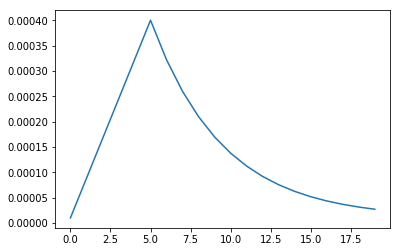

In [4]:
LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [5]:
GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition

# watch out for overfitting!
SKIP_VALIDATION = True
if SKIP_VALIDATION:
    TRAINING_FILENAMES = TRAINING_FILENAMES + VALIDATION_FILENAMES
## V20  
# VALIDATION_MISMATCHES_IDS = ['861282b96','df1fd14b4','b402b6acd','741999f79','4dab7fa08','6423cd23e','617a30d60','87d91aefb','2023d3cac','5f56bcb7f','4571b9509','f4ec48685','f9c50db87','96379ff01','28594d9ce','6a3a28a06','fbd61ef17','55a883e16','83a80db99','9ee42218f','b5fb20185','868bf8b0c','d0caf04b9','ef945a176','9b8f2f5bd','f8da3867d','0bf0b39b3','bab3ef1f5','293c37e25','f739f3e83','5253af526','f27f9a100','077803f97','b4becad84']
## V22
# VALIDATION_MISMATCHES_IDS = ['861282b96','617a30d60','4571b9509','f4ec48685','28594d9ce','6a3a28a06','55a883e16','9b8f2f5bd','293c37e25']
## V23
VALIDATION_MISMATCHES_IDS = []

Unhide to see `CLASSES`:

In [6]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

# Helper Functions
## Visualization

In [7]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None, figsize  = 13.0):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE =  figsize
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# Data Augmentation

In [8]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

def transform(image,label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]),label



## Datasets Functions

In [9]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
        
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def read_labeled_id_tfrecord(example):
    LABELED_ID_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_ID_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    idnum =  example['id']
    return image, label, idnum # returns a dataset of (image, label, idnum) triples

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_id_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    
    return dataset

def load_dataset_with_id(filenames, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_id_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.filter(lambda image, label, idnum: tf.reduce_sum(tf.cast(idnum == VALIDATION_MISMATCHES_IDS, tf.int32))==0)
    dataset = dataset.map(lambda image, label, idnum: [image, label])
    dataset = dataset.map(transform, num_parallel_calls=AUTO)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.filter(lambda image, label, idnum: tf.reduce_sum(tf.cast(idnum == VALIDATION_MISMATCHES_IDS, tf.int32))==0)
    dataset = dataset.map(lambda image, label, idnum: [image, label])
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset_with_id(ordered=False):
    dataset = load_dataset_with_id(VALIDATION_FILENAMES, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

# counting number of unique ids in dataset
def count_data_items(filenames):
    dataset = load_dataset(filenames,labeled = False)
    dataset = dataset.map(lambda image, idnum: idnum)
    dataset = dataset.filter(lambda idnum: tf.reduce_sum(tf.cast(idnum == VALIDATION_MISMATCHES_IDS, tf.int32))==0)
    uids = next(iter(dataset.batch(21000))).numpy().astype('U') 
    return len(np.unique(uids))

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = (1 - SKIP_VALIDATION) * count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 16465 training images, 0 validation images, 7382 unlabeled test images


## Display mismatches
This images from validation data seem to be really strange labeled.... :)

In [10]:
if len(VALIDATION_MISMATCHES_IDS)>0:
    dataset = load_dataset(TRAINING_FILENAMES,labeled = True)
    dataset = dataset.filter(lambda image, label, idnum: tf.reduce_sum(tf.cast(idnum == VALIDATION_MISMATCHES_IDS, tf.int32))>0)
    dataset = dataset.map(lambda image, label, idnum: [image, label])
    imgs = next(iter(dataset.batch(len(VALIDATION_MISMATCHES_IDS))))
    display_batch_of_images(imgs)

# Training Model

## Load Model into TPU

In [11]:
# Need this line so Google will recite some incantations
# for Turing to magically load the model onto the TPU
with strategy.scope():
    enet = efn.EfficientNetB7(
        input_shape=(512, 512, 3),
        weights='noisy-student',
        include_top=False
    )

    model = tf.keras.Sequential([
        enet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
        
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model.summary()

258072576/258068648 [==============================] - 8s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 16, 16, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               266344    
Total params: 64,364,024
Trainable params: 64,053,304
Non-trainable params: 310,720
_________________________________________________________________


## Training

In [12]:
#scheduler = tf.keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)

history = model.fit(
    get_training_dataset(), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[lr_callback],
    validation_data=None if SKIP_VALIDATION else get_validation_dataset()
)

Train for 128 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/20
128/128 [==============================] - 426s 3s/step - loss: 4.5489 - sparse_categorical_accuracy: 0.0688

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/20
128/128 [==============================] - 125s 980ms/step - loss: 3.0092 - sparse_categorical_accuracy: 0.3706

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/20
128/128 [==============================] - 126s 983ms/step - loss: 1.0593 - sparse_categorical_accuracy: 0.7451

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/20
128/128 [==============================] - 126s 983ms/step - loss: 0.5299 - sparse_categorical_accuracy: 0.8652

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
Epoch 5/20
128/128 [==============================] - 126s 983ms/step - loss: 0.3790 - sparse_categorical_accuracy: 0.9014

Epoch 00006

In [13]:
if not SKIP_VALIDATION:
    display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
    display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

## Training 2:

In [14]:
with strategy.scope():
    rnet = DenseNet201(
        input_shape=(512, 512, 3),
        weights='imagenet',
        include_top=False
    )

    model2 = tf.keras.Sequential([
        rnet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
        
model2.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model2.summary()

74842112/74836368 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 16, 16, 1920)      18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 104)               199784    
Total params: 18,521,768
Trainable params: 18,292,712
Non-trainable params: 229,056
_________________________________________________________________


In [15]:
history2 = model2.fit(
    get_training_dataset(), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS, 
    callbacks=[lr_callback],
    validation_data=None if SKIP_VALIDATION else get_validation_dataset()
)

Train for 128 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/20
128/128 [==============================] - 316s 2s/step - loss: 3.9952 - sparse_categorical_accuracy: 0.1714

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/20
128/128 [==============================] - 80s 624ms/step - loss: 1.6533 - sparse_categorical_accuracy: 0.6509

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/20
128/128 [==============================] - 76s 590ms/step - loss: 0.6707 - sparse_categorical_accuracy: 0.8472

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/20
128/128 [==============================] - 88s 686ms/step - loss: 0.4010 - sparse_categorical_accuracy: 0.9126

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
Epoch 5/20
128/128 [==============================] - 81s 631ms/step - loss: 0.3141 - sparse_categorical_accuracy: 0.9272

Epoch 00006: Le

In [16]:
if not SKIP_VALIDATION:
    display_training_curves(history2.history['loss'], history2.history['val_loss'], 'loss', 211)
    display_training_curves(history2.history['sparse_categorical_accuracy'], history2.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

# Finding best alpha
Our final model is just mix of two presented above. In the first commit it was arithmetic mean (alpha = 0.5). Note that using validation data as training will fit your model with accuracy equal 1.0.
Thus formula presented below of linear combination of models will work only with validation data:

prob = alpha  prob(model) + (1 - alpha)  prob(model2)

In [17]:
if not SKIP_VALIDATION:
    cmdataset = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
    images_ds = cmdataset.map(lambda image, label: image)
    labels_ds = cmdataset.map(lambda image, label: label).unbatch()
    cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch
    m = model.predict(images_ds)
    m2 = model2.predict(images_ds)
    scores = []
    for alpha in np.linspace(0,1,100):
        cm_probabilities = alpha*m+(1-alpha)*m2
        cm_predictions = np.argmax(cm_probabilities, axis=-1)
        scores.append(f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro'))
        
    print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
    print("Predicted labels: ", cm_predictions.shape, cm_predictions)
    plt.plot(scores)
    best_alpha = np.argmax(scores)/100
    cm_probabilities = best_alpha*m+(1-best_alpha)*m2
    cm_predictions = np.argmax(cm_probabilities, axis=-1)
else:
    best_alpha = 0.51

In [18]:
print(best_alpha)

0.51


# Mismatches on a validation data

In [19]:
if not SKIP_VALIDATION:
    
    cmdataset_with_id = get_validation_dataset_with_id(ordered=True)
    ids_ds = cmdataset_with_id.map(lambda image, label, idnum: idnum).unbatch()
    ids = next(iter(ids_ds.batch(NUM_VALIDATION_IMAGES))).numpy().astype('U') # get everything as one batch

    val_batch = iter(cmdataset.unbatch().batch(1))
    noip = sum(cm_predictions!=cm_correct_labels)
    print('Number of incorrect predictions: ' + str(noip) + ' ('+str(round(noip/NUM_VALIDATION_IMAGES*100,1))+'%)')
    for fi in range(NUM_VALIDATION_IMAGES):
        x = next(val_batch)
        if cm_predictions[fi] != cm_correct_labels[fi]:
            print("Image id: '" + ids[fi] + "'")
            display_batch_of_images(x,np.array([cm_predictions[fi]]),figsize = 2)

# Confusion matrix

In [20]:
if not SKIP_VALIDATION:
    cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
    score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    #cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
    display_confusion_matrix(cmat, score, precision, recall)
    print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

# Predictions

In [21]:
test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = best_alpha*model.predict(test_images_ds) + (1-best_alpha)*model2.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')

Computing predictions...
[ 67  28  83 ...  86 102  62]
Generating submission.csv file...
